# 0. EXAMPERIMENT TEMPLATE - EXAMPLE OF USAGE

In this nottebok the effectiveness of the IP algorithm, implemented with the pytorch automatic-differentiation will be proved.

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

In this example the NARMA10 task will be used. Data are imported on the fly from a .csv file. 

In [3]:
from DATA import NARMA10

data = NARMA10(True, [70,0,30])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## Build up a Reservoir with Intrinsic Plasticity

The IP Reservoir is characterized by a target distribution each neuron has to reach.  

The set of the target distributions is contained in the IPMask object. 
In this case the mask contains only Gaussian distributions centered in 0 with standard deviation 1 (Normal distributions), 
following the Entropy Maximization principle mentioned in the IP paper. 

The number of the distribution contained in the mask  must be the same of the neurons in the Reservoir. 

The other parameters concerns the reservoir initialization (i.e. the desider sparsity and spectral radius).

In [4]:
from IPReservoir import IPReservoir
from IntrinsicPlasticity import IPMask

# Build a reservoir of 250 units, with IP targeting 50 equal Normal distributions. 
# For the current example, sparsity and spectral radius were setted to avoid explding values of gradient. 
# Input and recurrent biases have been switched off (set to zero), letting the IP biases alone dominate. 

ip_reservoir = IPReservoir( N=50, sparsity=0.4, ro_rescale=0.8, mask=IPMask.normalMask(50), bias=False)

In [5]:
# Warning - pre training for a large number of epochs may cause RAM running off issues.  
ip_reservoir.pre_train(X_TR, eta=0.00025, epochs=5,  learning_rule="autodiff", verbose=True)

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\autograd\__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


- Epoch: 1) | KL Divergence value: 1357.820068359375.
- Epoch: 2) | KL Divergence value: 1290.2271728515625.
- Epoch: 3) | KL Divergence value: 1267.645751953125.
- Epoch: 4) | KL Divergence value: 1257.1807861328125.
- Epoch: 5) | KL Divergence value: 1250.125732421875.


Printed KL divergence is calculated in a sample based way, according to torch implementation of the metric. 

Many reduction of it are provided, in this implementation the "sum" reduction has been chosen, which provides generally "larger" values of the KL and of its gradient. Such values has to be compensated using a small learning rate. 

The current implementation turned out to be seriously memory inefficient: with a large number of units in the reservoir and some thousand of timesteps to be processed, the computational graph built up to differentiate the KL, early saturate the whole RAM. 

For such a reason, the usage of the analytical learning rule is generally preferable. 

## Check IP effectiveness

To check wether the pre training has been effective, we process some unseen data, expeting them to approach a Normal distribution. 

To graphically compare the new output with the distribution we need to resample a (smaller) batch of data of the same lenght. 

In [6]:
# Process validation data to check wether the target distribution as been reached or at least approached.

ip_reservoir.sample_targets(X_TS.shape[0], True)
ip_reservoir.predict(X_TS, save_gradients=False, save_states=True)

tensor([[-0.1255,  0.1486, -0.1121,  ..., -0.1632, -0.0974, -0.0648],
        [-0.0784,  0.0949, -0.0645,  ..., -0.1511, -0.1408, -0.0387],
        [-0.0815,  0.0431, -0.0797,  ..., -0.0958, -0.0939, -0.0212],
        ...,
        [-0.0989,  0.2717, -0.0850,  ..., -0.2775, -0.0572,  0.1192],
        [-0.0966,  0.2530,  0.0584,  ..., -0.1641, -0.0999, -0.0079],
        [-0.1717, -0.0157, -0.1632,  ..., -0.2208, -0.3076, -0.0886]],
       grad_fn=<CopySlices>)

We can check the shape of the actual and the desired distribution across some precise neuron

Or check the distribution of all the outputs of all the neurons of the reservoir (more interesting and meaningful). 

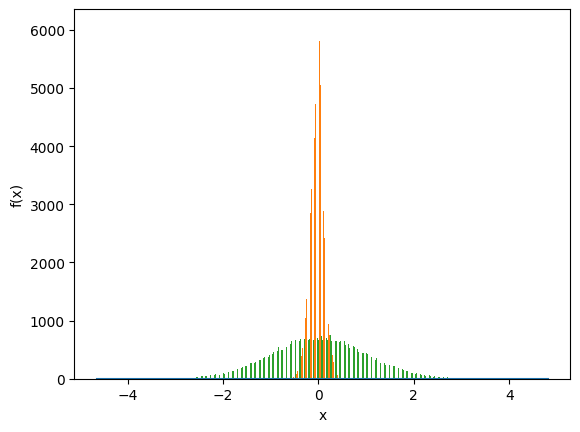

In [7]:
ip_reservoir.plot_global_neural_activity()

We can also print the statistics of some precise neuron, and of the whole reservoir. 

In [8]:
ip_reservoir.print_IP_stats([1,4])

Unit - (2): [ ACTUAL_MEAN == (0.13367943465709686)  ACTUAL_STD == (0.10356441885232925)][ TARGET_MEAN == (-0.025658510625362396) TARGET_STD == (1.010866641998291)]
Unit - (5): [ ACTUAL_MEAN == (0.1787862777709961)  ACTUAL_STD == (0.0953398123383522)][ TARGET_MEAN == (-0.008897249586880207) TARGET_STD == (1.0065244436264038)]
Overall network: [ACTUAL_MEAN == (-0.024281613528728485)  ACTUAL_STD == (0.14143531024456024)]


## Training the readout

Once the pre-training phase has endend, we can build a linear readout on the top of the reservoir, to solve the downstream task. 

In this exaple, no hyperparameter search is carried on. 

Anyway lambada value used for the readout tranining (ridge regression), turned out to be crucial to reveal the benefit of the IP pre training. 

In [9]:
from ESN import EchoStateNetwork

network = EchoStateNetwork(ip_reservoir)

# Train a linear readout with ridge regression.  
# The number of units is inferred from the N value of the reservoir and from the shape of the Y target signal. 

# The lambda optimal value (mabye not 0.25) should be searched in a quite thin range. 

network.train(X_TR, Y_TR, 0, transient=100, verbose=True)

Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.52391e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


array([0.25940466, 0.25056553, 0.25293398, ..., 0.2581148 , 0.23539138,
       0.26499104], dtype=float32)

## Evaluating the ESN

MEAN ERROR -0.003300264563238484
MEAN SQUARED ERROR: 0.021164342351902968
NORMALIZED ROOT-MEAN SQUARE ERROR: 2.1483270851466596
MEMORY CAPACITY: 1.1129043102264404


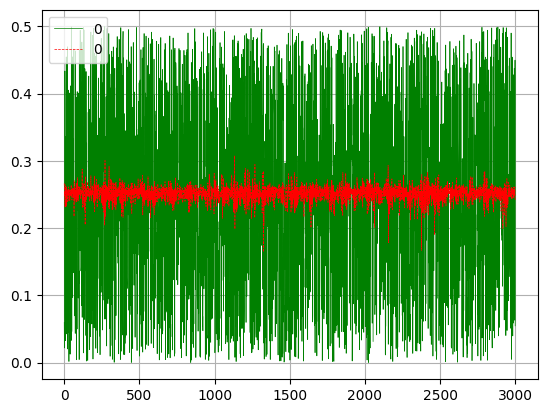

In [10]:
from Metrics import MSE, ME, NRMSE

print(f"MEAN ERROR { network.evaluate(X_TS, Y_TS, metric=ME()) }")
print(f"MEAN SQUARED ERROR: { network.evaluate(X_TS, Y_TS, metric=MSE())}" )
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { network.evaluate(X_TS, Y_TS, metric=NRMSE(), plot=True)}" )

print(f"MEMORY CAPACITY: {network.MemoryCapacity(l=200, tau_max=10)}")